In [1]:
!pip install torch torchvision opencv-python numpy
!pip install "deeplake<4"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.4/643.4 kB 31.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.4 MB/s eta 0:00:

rel_high:(low,med,high)high
(1600, 1200, 3)


/tmp/ipython-input-2435578040.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  magma_cmap = plt.cm.get_cmap('magma')


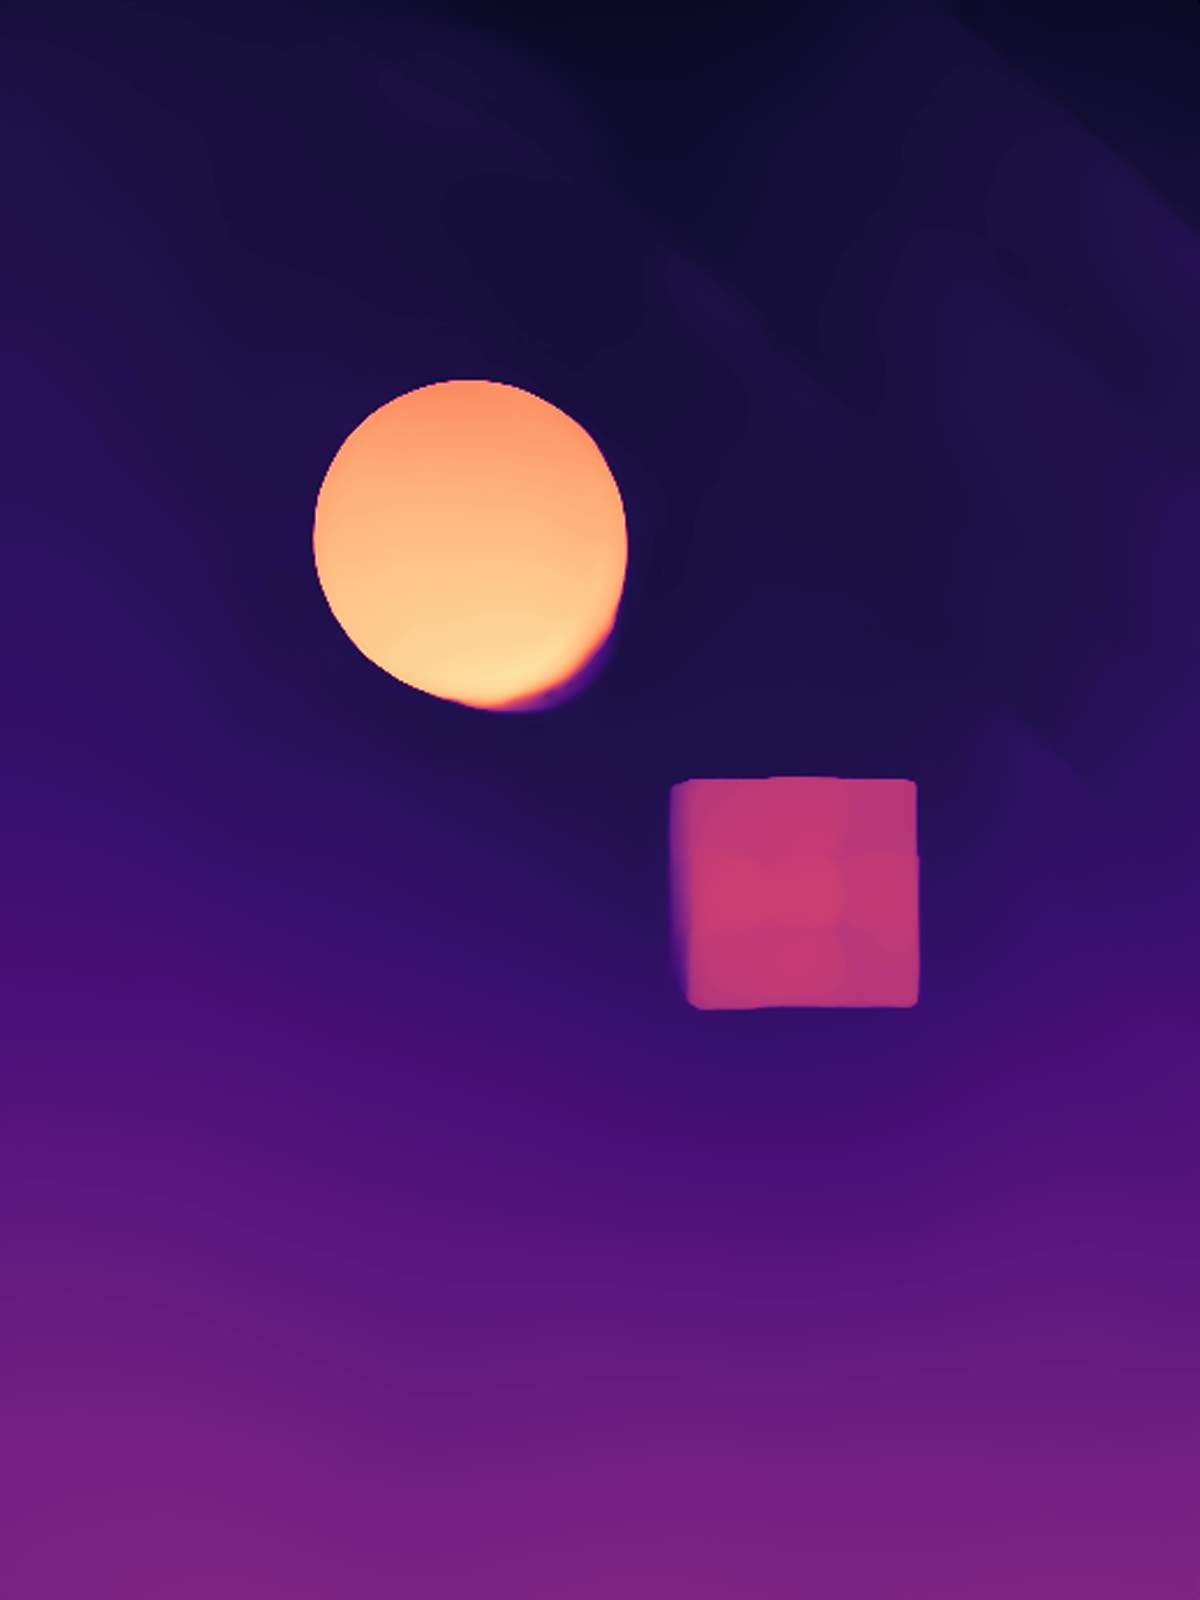

In [346]:
import cv2
from google.colab.patches import cv2_imshow
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

img = cv2.imread("whole_test_2.jpg")
relative_heigh_ration = input("rel_high:(low,med,high)")       # Replace with your image path
initial_image = img.copy()
print(initial_image.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for model
img = Image.fromarray(img_rgb)

model_id = "depth-anything/Depth-Anything-V2-Small-hf"
processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModelForDepthEstimation.from_pretrained(model_id)

inputs = processor(images=img, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

post_processed = processor.post_process_depth_estimation(
    outputs, target_sizes=[(img.height, img.width)]
)

depth_result = post_processed[0]
if "predicted_depth" in depth_result:
    depth = depth_result["predicted_depth"].squeeze().cpu().numpy()
elif "depth" in depth_result:
    depth = depth_result["depth"].squeeze().cpu().numpy()
else:
    raise KeyError(f"Could not find depth key in output. Available keys: {depth_result.keys()}")

depth_norm = (depth - depth.min()) / (depth.max() - depth.min())

# Get the magma colormap
magma_cmap = plt.cm.get_cmap('magma')
depth_magma = magma_cmap(depth_norm)
# Convert to RGB uint8 (0-255) by removing alpha channel
depth_magma_rgb = (depth_magma[:, :, :3] * 255).astype(np.uint8)
depth_color = cv2.cvtColor(depth_magma_rgb,cv2.COLOR_RGB2BGR)
cv2_imshow(depth_color)

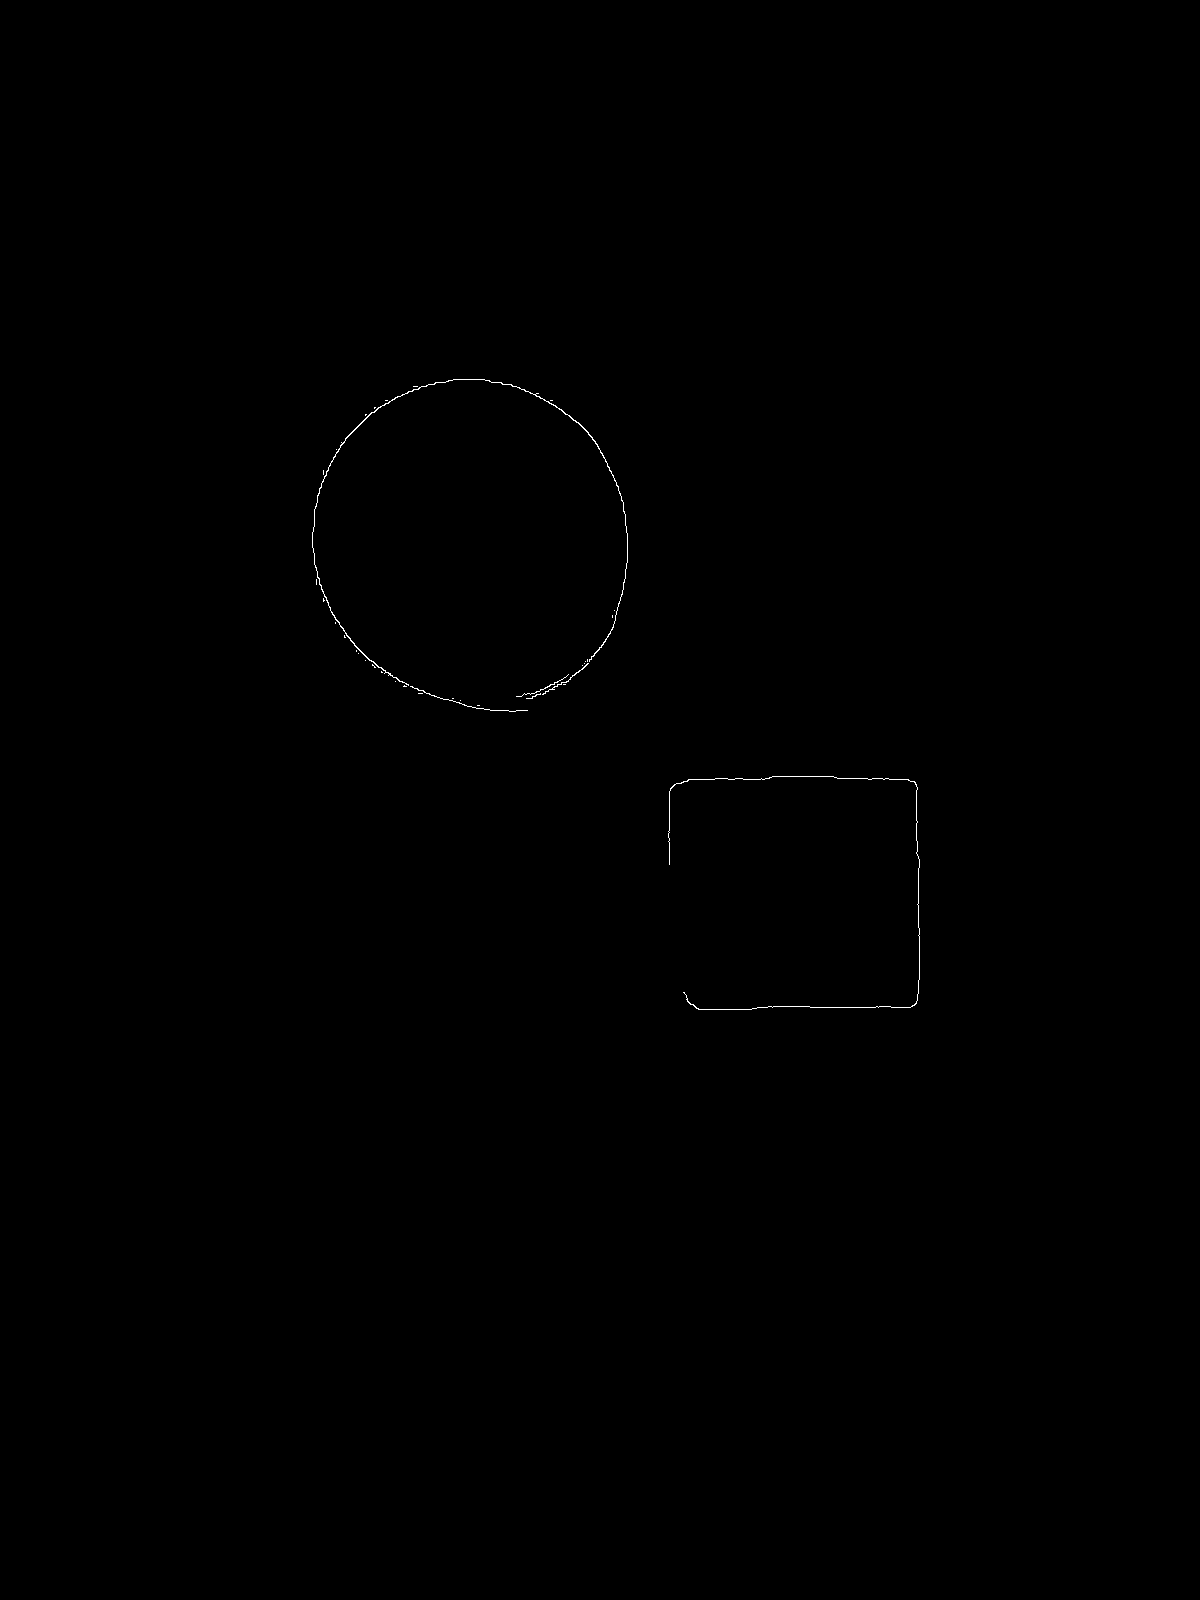

In [347]:
kernel = np.array([[-1,-1,-1],
                   [-1, 8,-1],
                   [-1,-1,-1]])
laplacian = cv2.filter2D(depth_color, -1, kernel)
edges = cv2.Canny(depth_color, 100, 200)
cv2_imshow(edges)

In [348]:
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

temp = depth_color.copy()
gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).flatten()

# --- Step 3: Apply Gaussian smoothing to the histogram ---
sigma = 1.89  # adjust for more/less blur
smoothed_hist = gaussian_filter1d(hist, sigma=sigma)

Enter number of objects: 2
[ 85 118 129 140 154 185 196 204]


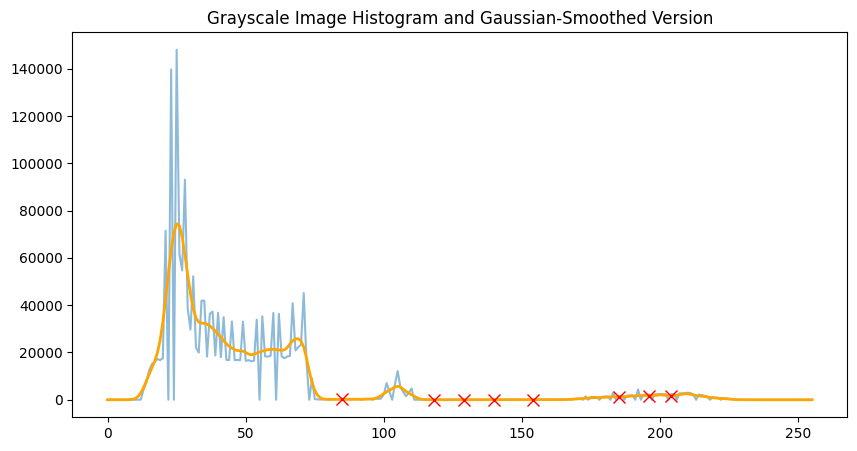

 spacing 
[125.2 195. ]


In [351]:
nom_of_abjects = int(input("Enter number of objects: "))
if(relative_heigh_ration == "low"):
  low_bound = 110
  error_rct = 1.08
if(relative_heigh_ration == "med"):
  low_bound = 100
  error_rct = 1.23
if(relative_heigh_ration == "high"):
  low_bound=80
  error_rct = 2.91
if(relative_heigh_ration == "vhigh"):
  low_bound=60
derivative = np.gradient(smoothed_hist[low_bound:])
zero_crossings = np.where(np.diff(np.sign(derivative)))[0]
maxima = np.array([i for i in zero_crossings if derivative[i-1] > 0 and derivative[i+1] < 0]).astype(int) + low_bound
minima = np.array([i for i in zero_crossings if derivative[i-1] < 0 and derivative[i+1] > 0]).astype(int) + low_bound
ToLeReNcE = 3
print(minima)
plt.figure(figsize=(10, 5))
plt.plot(hist, label='Original Histogram', alpha=0.5)
plt.plot(smoothed_hist, label=f'Gaussian Blurred Histogram (σ={sigma})', linewidth=2, color='orange')
plt.plot(minima, smoothed_hist[minima], 'rx', label='New Points', markersize=8)
plt.title('Grayscale Image Histogram and Gaussian-Smoothed Version')
plt.show()

kmeans = KMeans(n_clusters=nom_of_abjects, random_state=42)
kmeans.fit(minima.reshape(-1,1))
labels, centers = kmeans.labels_, kmeans.cluster_centers_
print(" spacing ")
bemp = centers.reshape(len(centers))
ascending = np.sort(bemp)
print(ascending)

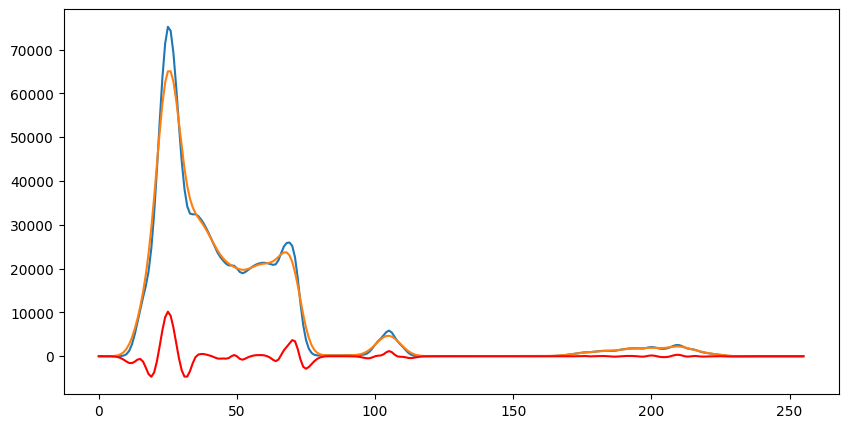

In [352]:
example_hist = hist.copy()
sigma1 = 1.8               #Why Minima over DoG is explained by graph
sigma2 = 3
smoothed_hist1 = gaussian_filter1d(example_hist, sigma=sigma1)
smoothed_hist2 = gaussian_filter1d(example_hist, sigma=sigma2)
plt.figure(figsize=(10, 5))
plt.plot(smoothed_hist1)
plt.plot(smoothed_hist2)
plt.plot(smoothed_hist1-smoothed_hist2, color='red')
dog = smoothed_hist1-smoothed_hist2
plt.show()

In [353]:
print(minima)
print(labels)
print("ascending: ",ascending)

[ 85 118 129 140 154 185 196 204]
[0 0 0 0 0 1 1 1]
ascending:  [125.2 195. ]


195.0
vvv Ground Truth vvv


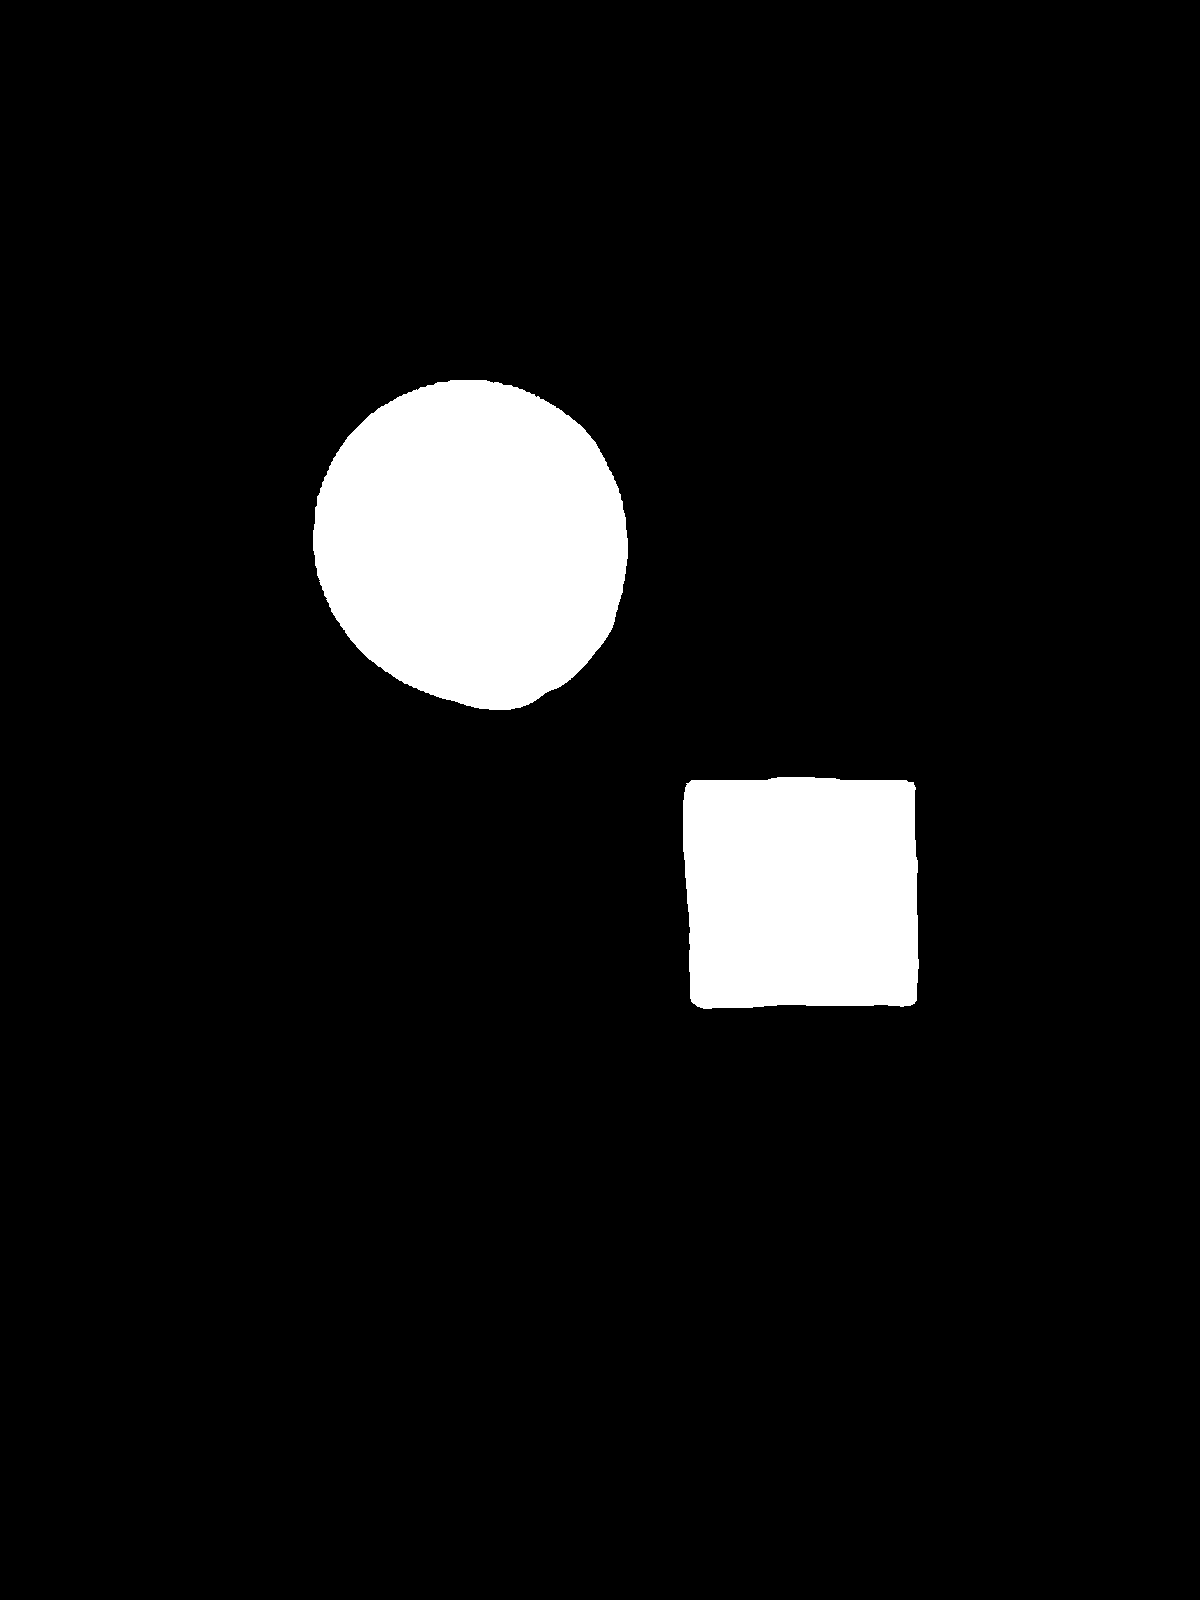

<class 'numpy.int64'>


In [354]:
ground_truth = minima[0]
hmm2 = ascending[1]
print(hmm2)
ret, thresh2 = cv2.threshold(gray, ground_truth,255,cv2.THRESH_BINARY)
print("vvv Ground Truth vvv")
cv2_imshow(thresh2)
print(type(ground_truth))

In [355]:
def small_area_remover(binary):
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)
# output removes the smaller area(corrupted segment)
  output = np.zeros_like(binary)
  if num_labels > 1:
        areas = stats[1:, cv2.CC_STAT_AREA]
        largest_component_label = np.argmax(areas) + 1  # +1 because we excluded background
        output[labels == largest_component_label] = 255
  return output

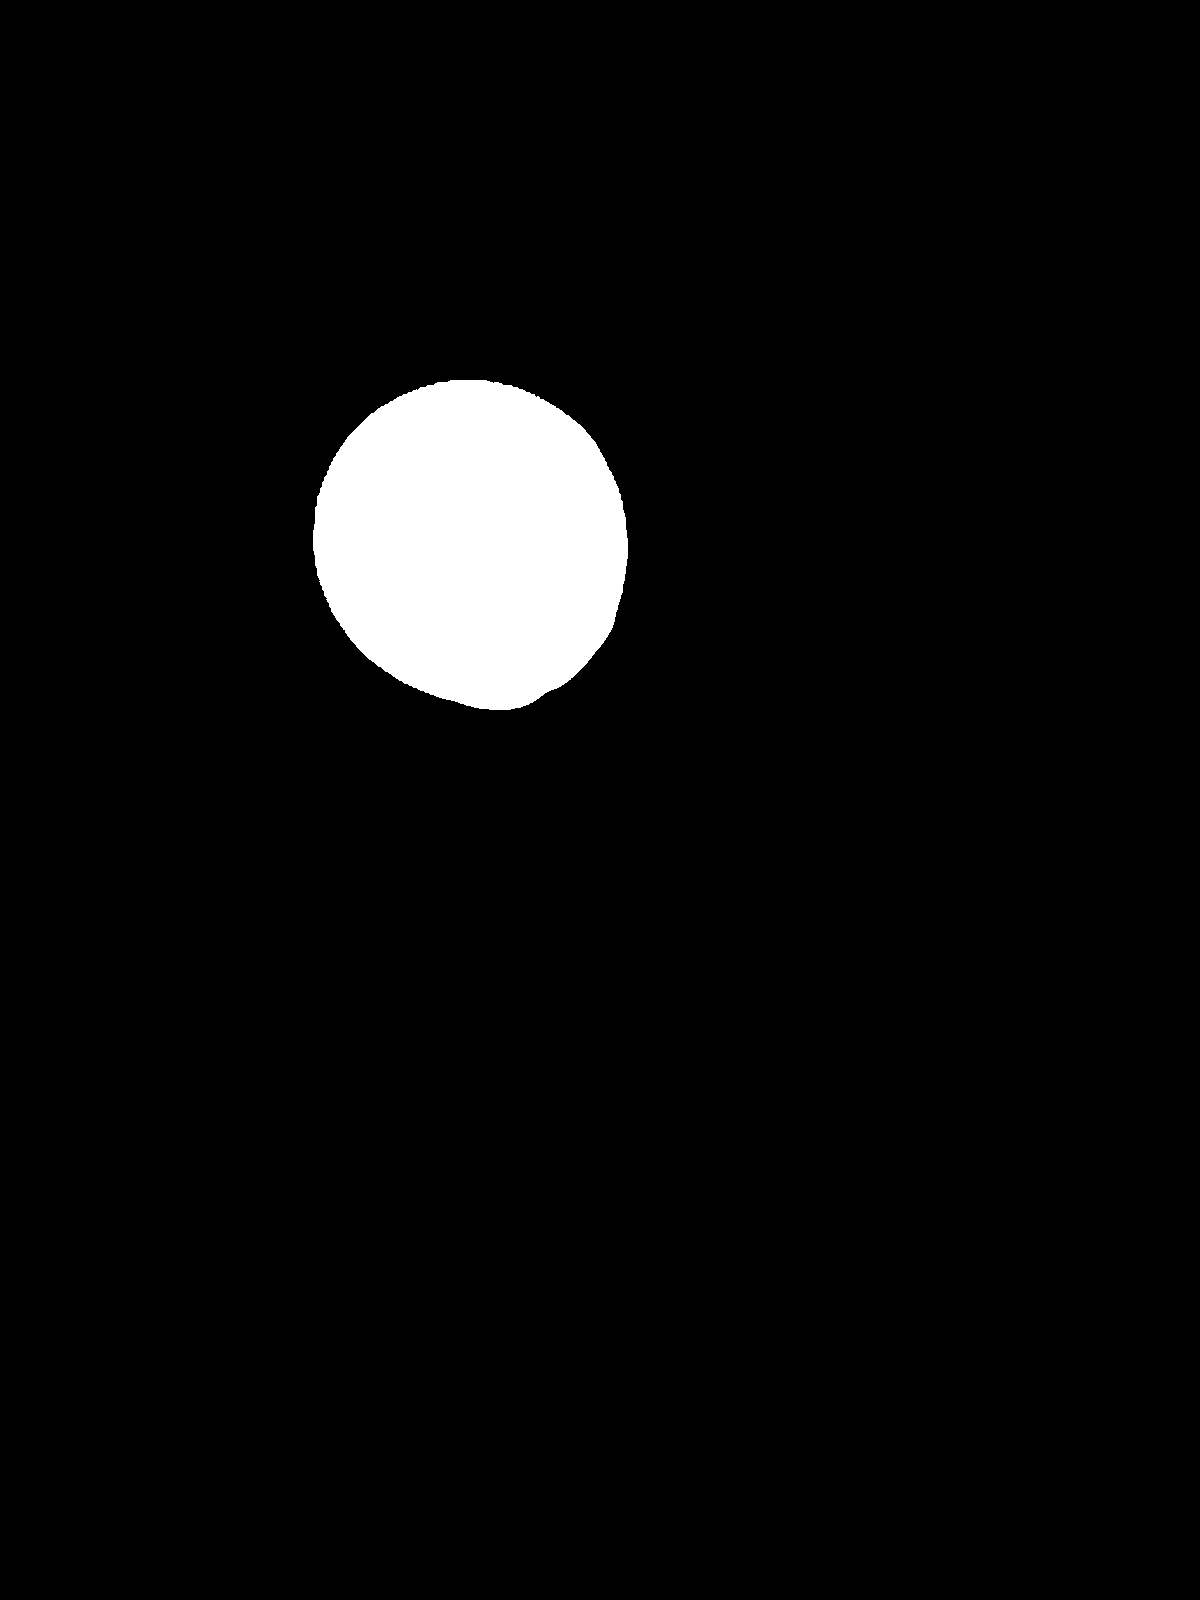

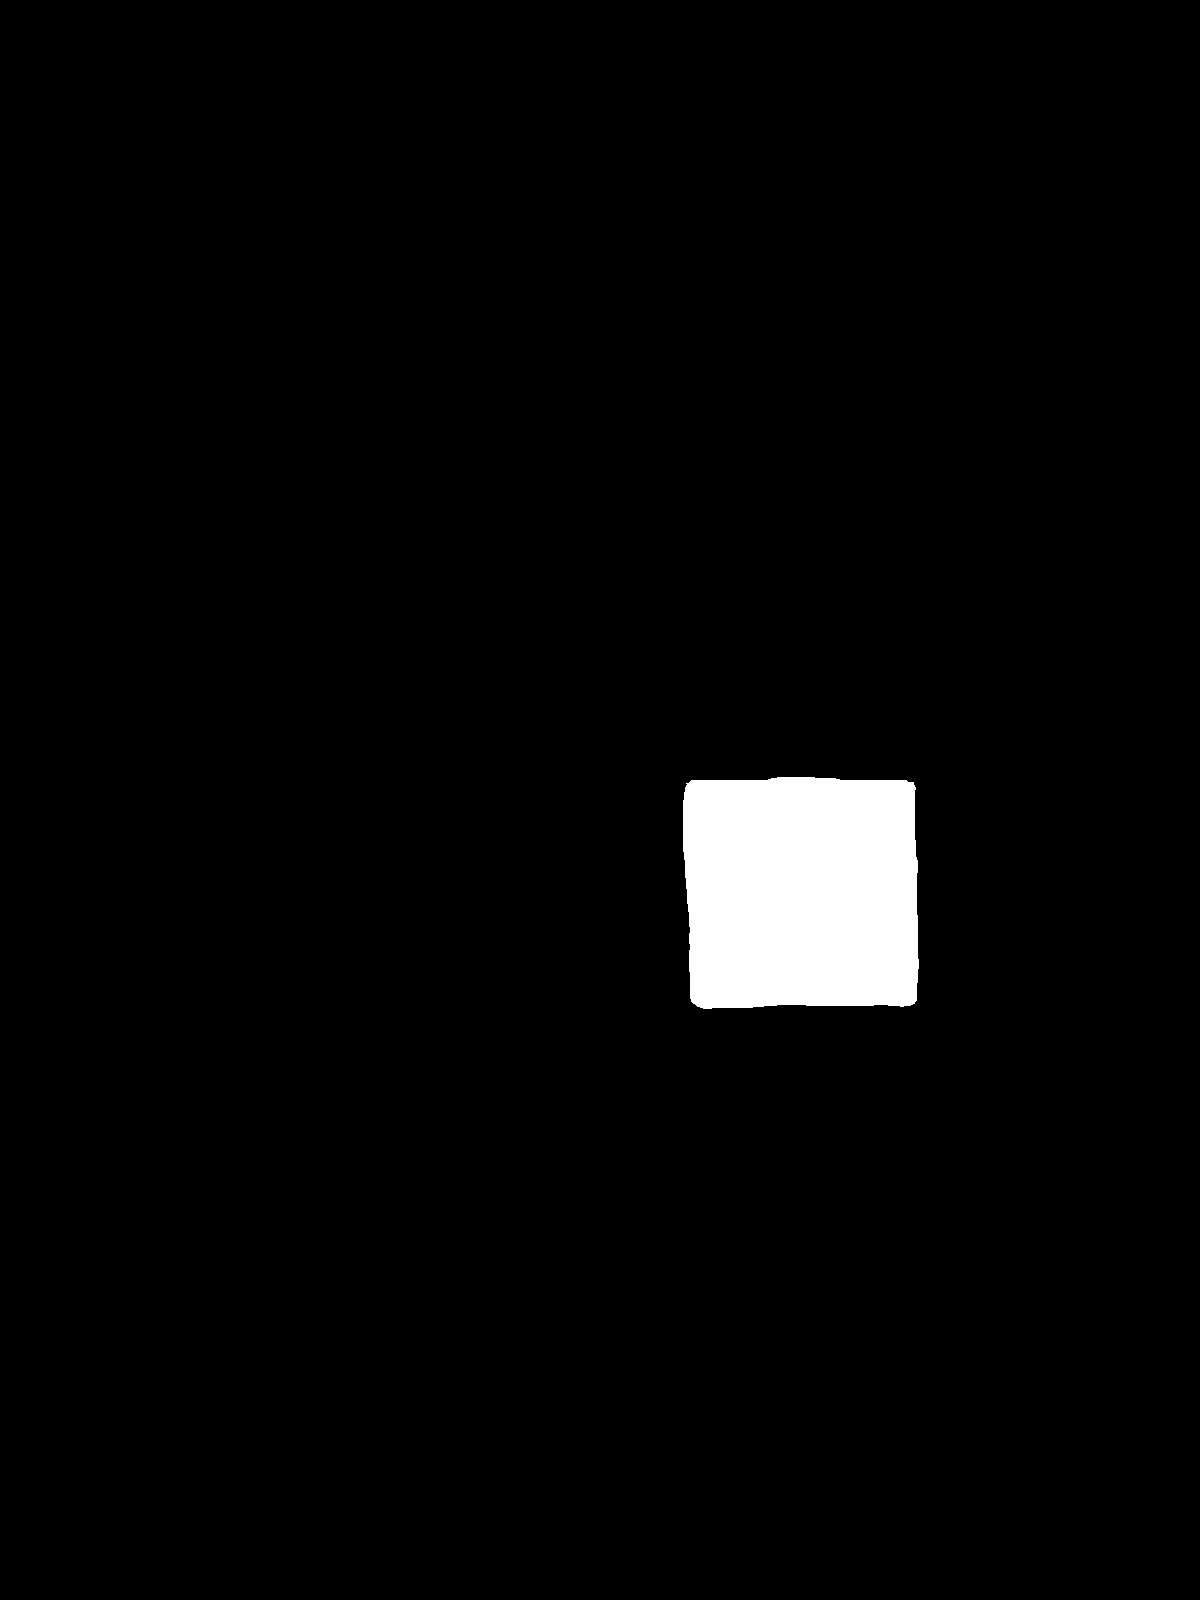

In [356]:
ret, ground = cv2.threshold(gray, ground_truth,255,cv2.THRESH_BINARY)
if(nom_of_abjects > 1):
  masks = {}
  for i in range(1, nom_of_abjects):
    _, thresh = cv2.threshold(gray, ascending[i], 255, cv2.THRESH_BINARY)
    binary = ground - thresh
    output = small_area_remover(binary)
    masks[i] = output

# Calculate sum AFTER the loop, using the masks
  sum = np.zeros(gray.shape, dtype=np.uint8)  # Initialize as uint8
  for i in range(1, nom_of_abjects):
      sum = cv2.add(sum, masks[i])
  residual = cv2.subtract(ground, sum)
  _, residual = cv2.threshold(residual, 1, 255, cv2.THRESH_BINARY)
  masks[0] = small_area_remover(residual)
elif(nom_of_abjects == 1):
  masks = {0: small_area_remover(ground)}

for i in range(nom_of_abjects):
    cv2_imshow(masks[i])


In [357]:
'''for i in range(1,nom_of_abjects):
  masks = {}
  _,threshs = cv2.threshold(gray, ascending[i], cv2.THRESH_BINARY)
  '''

'for i in range(1,nom_of_abjects):\n  masks = {}\n  _,threshs = cv2.threshold(gray, ascending[i], cv2.THRESH_BINARY)\n  '

#MEASUREMENT
we will do 3 shapes
1. cuboid
2. cylinder
3. sphere maybe
the only place where we use ml is for figuring out the depth map

> Add blockquote

cam=(0,0,0)
find the closest corner P1(x1,y1,z1), we must place object s.t we know x1^2+y1^2+z1^2,  then find 3 main points of the thresholded mask Left most point P2, Right most point P3, Bottom most point P4 w.r.t pixel coords.

In [358]:
def merge_colinear_lines(lines, angle_threshold=5, distance_threshold=20):
    """Merge and extend colinear line segments."""
    if lines is None:
        return []

    merged_lines = []

    def line_angle(l):
        x1, y1, x2, y2 = l
        return np.degrees(np.arctan2(y2 - y1, x2 - x1))

    def endpoint_distance(l1, l2):
        x11, y11, x12, y12 = l1
        x21, y21, x22, y22 = l2
        dist1 = np.hypot(x11 - x21, y11 - y21)
        dist2 = np.hypot(x11 - x22, y11 - y22)
        dist3 = np.hypot(x12 - x21, y12 - y21)
        dist4 = np.hypot(x12 - x22, y12 - y22)
        dists = np.array([dist1,dist2,dist3,dist4])
        #print(type(dist1))
        min_dist = np.min(dists)
        return min_dist

    for line in lines:
        x1, y1, x2, y2 = line[0]
        merged = False
        for i, mline in enumerate(merged_lines):
            if abs(line_angle(line[0]) - line_angle(mline)) < angle_threshold and endpoint_distance(line[0], mline) < distance_threshold:
                # Extend to outermost points
                all_points = np.array([[x1, y1], [x2, y2], [mline[0], mline[1]], [mline[2], mline[3]]])
                x_coords = all_points[:, 0]
                y_coords = all_points[:, 1]
                if abs(x_coords[0] - x_coords[1]) > abs(y_coords[0] - y_coords[1]):
                    idx_min = np.argmin(x_coords)
                    idx_max = np.argmax(x_coords)
                else:
                    idx_min = np.argmin(y_coords)
                    idx_max = np.argmax(y_coords)
                merged_lines[i] = [x_coords[idx_min], y_coords[idx_min], x_coords[idx_max], y_coords[idx_max]]
                merged = True
                break
        if not merged:
            merged_lines.append([x1, y1, x2, y2])
    return merged_lines

In [359]:
def sad(camheight,depthmap,mask,viewport=[3.4,3.6],f=6.5,imgsize=[initial_image.shape[0],initial_image.shape[1]]):
  img = depthmap
# masks, callibration(camheight, viewport-(x,y),f length), depthmap, imgsize =1920x1080
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  bing=mask
  binary=cv2.cvtColor(bing,cv2.COLOR_GRAY2BGR)
#shi tomasi
  corners = cv2.goodFeaturesToTrack(bing, 10, 0.05, 50)
  corners = np.int32(corners)
  imgc=binary.copy()

#drawing circles
  for i in corners:
    x, y = i.ravel()
    cv2.circle(imgc, (x, y), 3, (0, 0, 255), -1)

  #cv2_imshow(imgc)
  imgl=binary.copy()
  edges = cv2.Canny(binary, 20, 50, apertureSize=3)
#cv2_imshow(edges)

  linesP = cv2.HoughLinesP(edges, 0.5, np.pi / 720, threshold=10,
                         minLineLength=70, maxLineGap=20)

  if linesP is not None:
    for line in linesP:
        x1, y1, x2, y2 = line[0]
        cv2.line(imgl, (x1, y1), (x2, y2), (0, 255, 0), 2)

#cv2_imshow(imgl)

  imglm=imgl.copy()
  if linesP is not None:
    # Merge colinear lines
    merged_lines = merge_colinear_lines(linesP,15,400)
    # Draw merged lines
    for x1, y1, x2, y2 in merged_lines:
        cv2.line(imglm, (x1, y1), (x2, y2), (0, 255, 0), 2)

  cv2_imshow(imglm)
  x_min = np.min(corners[:,:, 0])
  y_min = np.min(corners[:,:, 1])
  x_max = np.max(corners[:,:, 0])
  y_max = np.max(corners[:,:, 1])

  top_left = (x_min, y_min)
  bottom_right = (x_max, y_max)

  bing=cv2.cvtColor(bing,cv2.COLOR_GRAY2BGR)
  '''cv2.rectangle(img,top_left , bottom_right, (0, 255, 0), 2)
  cv2.putText(img,"hola",(x_min,y_max),cv2.FONT_HERSHEY_SIMPLEX,fontScale=2,thickness=3,color = (0, 255, 0))
  cv2_imshow(img)
  print(x_max-x_min,y_max-y_min)'''

  dx=x_max-x_min
  dy=y_max-y_min
  return [dx,dy,(x_min,y_min),(x_max,y_max)]
def view(dx,dy,px,py,camh=300,cx=0.82,cy=0.79,f=6.5,viewport=[3.6,6.4]) :                    #####################################

  tx=(dx/px)*viewport[1]
  ty=(dy/py)*viewport[0]

  x=(camh/f)*tx
  y=(camh/f)*ty

  return [(cx)*x,(cy)*y]

In [360]:
def vertical_text(img, text, org, font=cv2.FONT_HERSHEY_SIMPLEX, scale=1, color=(0,255,0),
    thickness=3, lineType=cv2.LINE_AA, method="rotate", spacing=40, angle=90):
    x, y = org
    img_out = img.copy()

    if method == "stack":
        for ch in text:
            cv2.putText(img_out, ch, (x, y), font, scale, color, thickness, lineType)
            y += spacing

    elif method == "rotate":
        # Get text size
        (text_w, text_h), baseline = cv2.getTextSize(text, font, scale, thickness)
        text_img = np.zeros((text_h + baseline, text_w, 3), dtype=np.uint8)
        cv2.putText(text_img, text, (0, text_h), font, scale, color, thickness, lineType)

        # Rotate text image
        M = cv2.getRotationMatrix2D((text_w//2, text_h//2), angle, 1.0)
        cos, sin = np.abs(M[0, 0]), np.abs(M[0, 1])
        nW = int((text_h * sin) + (text_w * cos))
        nH = int((text_h * cos) + (text_w * sin))
        M[0, 2] += (nW / 2) - text_w // 2
        M[1, 2] += (nH / 2) - text_h // 2

        rotated = cv2.warpAffine(text_img, M, (nW, nH), flags=cv2.INTER_LINEAR, borderValue=(0,0,0))

        h, w = rotated.shape[:2]
        if y + h <= img_out.shape[0] and x + w <= img_out.shape[1]:
            img_out[y:y+h, x:x+w] = np.where(rotated>0, rotated, img_out[y:y+h, x:x+w])
        else:
            print("Warning: text goes out of image bounds")

    else:
        raise ValueError("method must be 'rotate' or 'stack'")

    return img_out
def mean_depth(depth,lt_p,rb_p):
  lx,ly = lt_p
  rx,ry = rb_p
  return np.mean(depth[ly:ry,lx:rx])

Enter Cam Height:300
Enter Reference Obj Height53


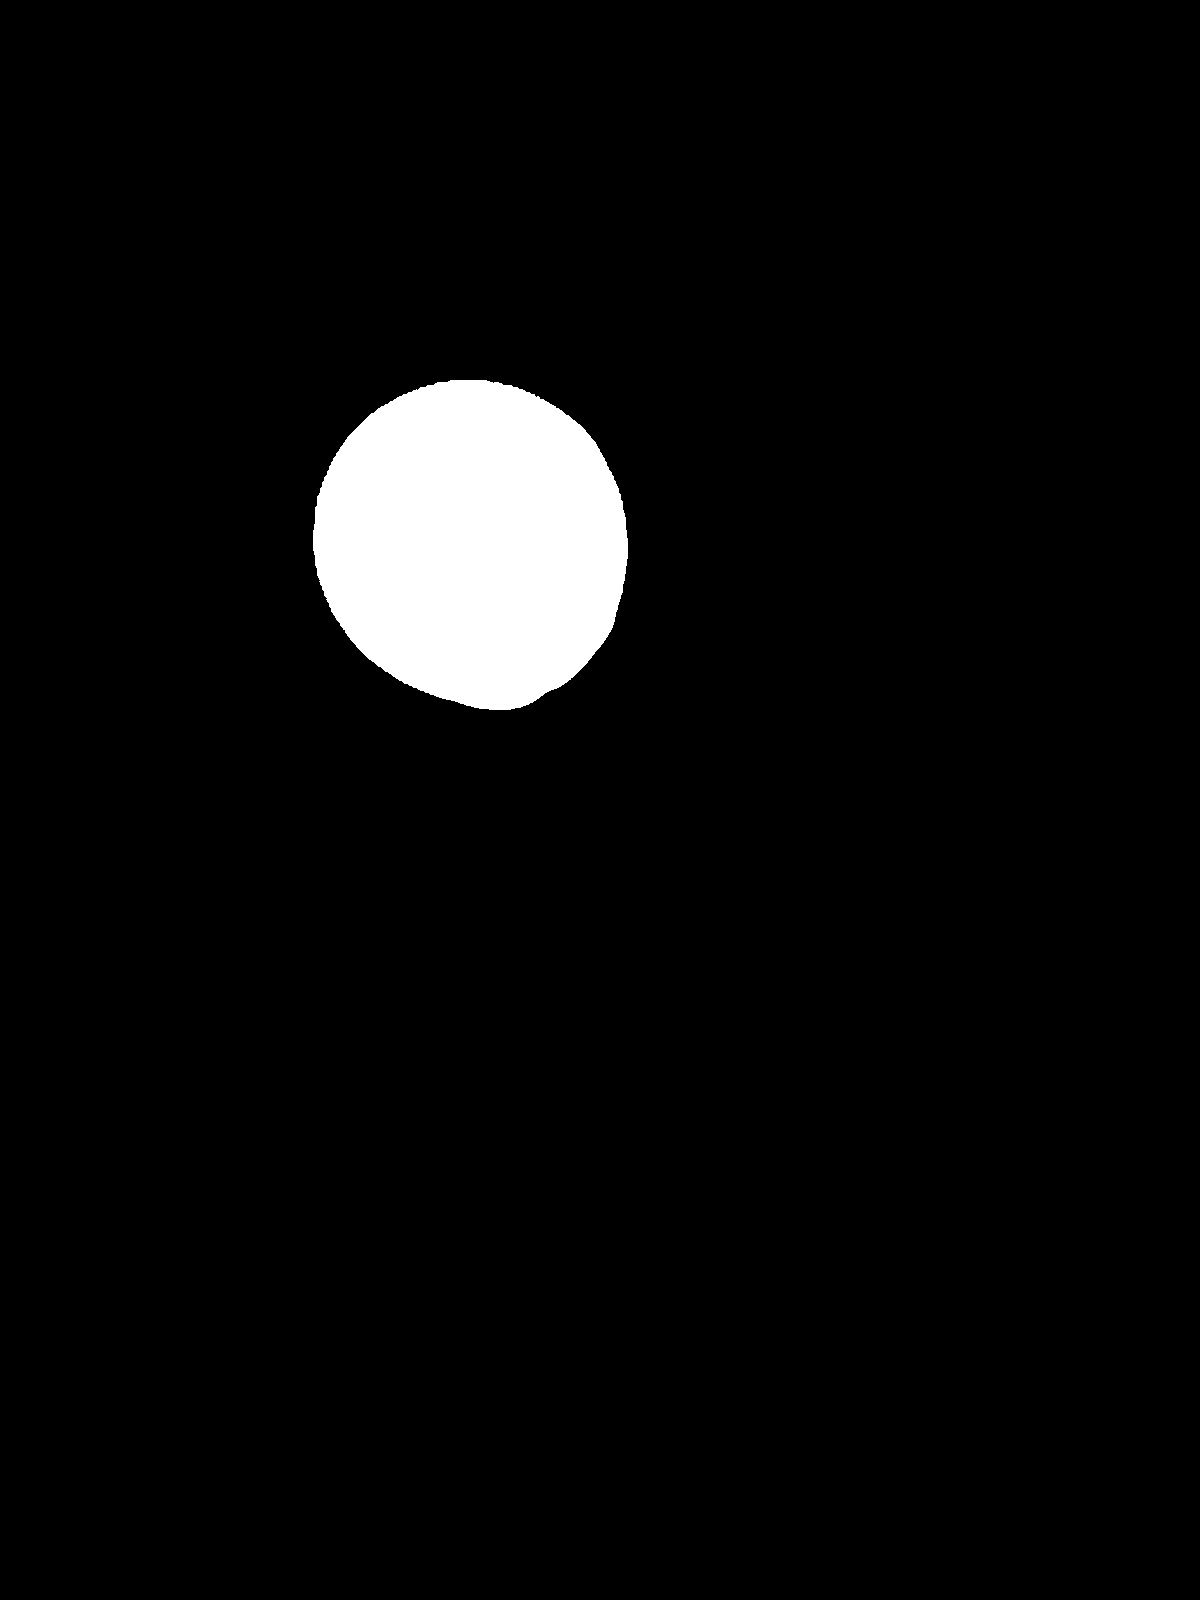

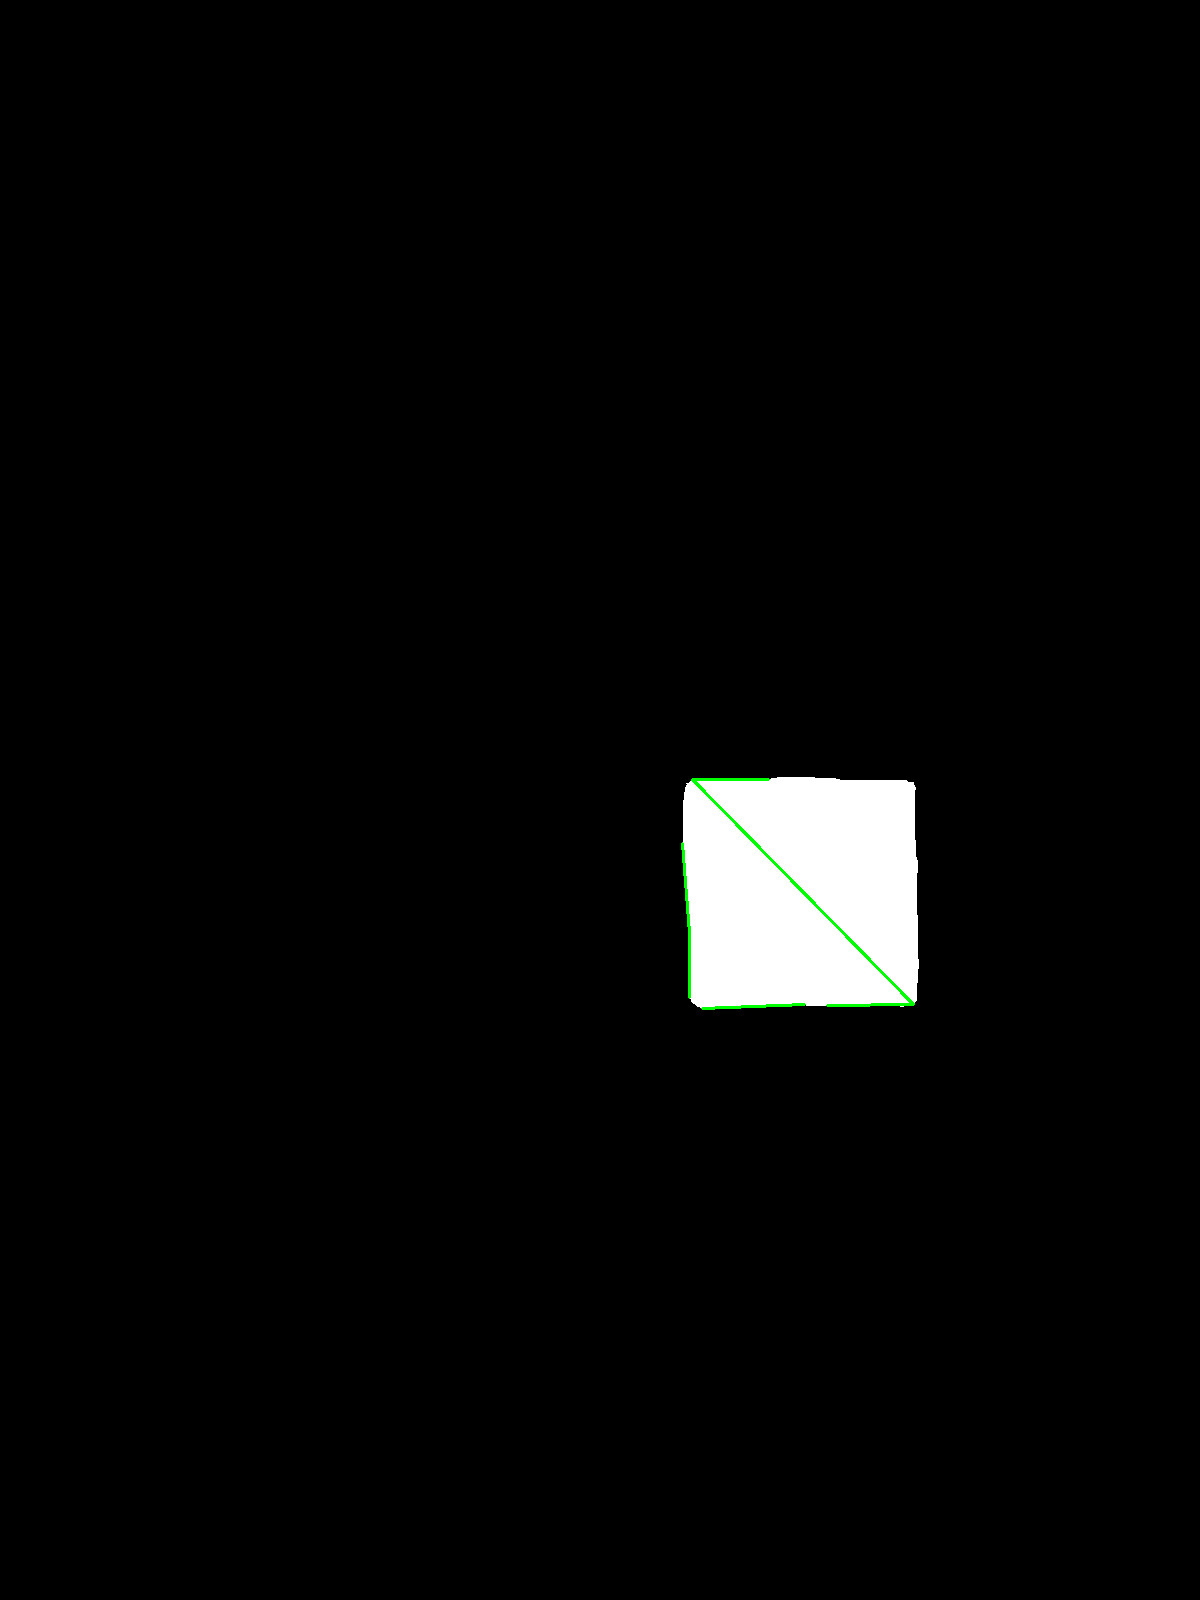

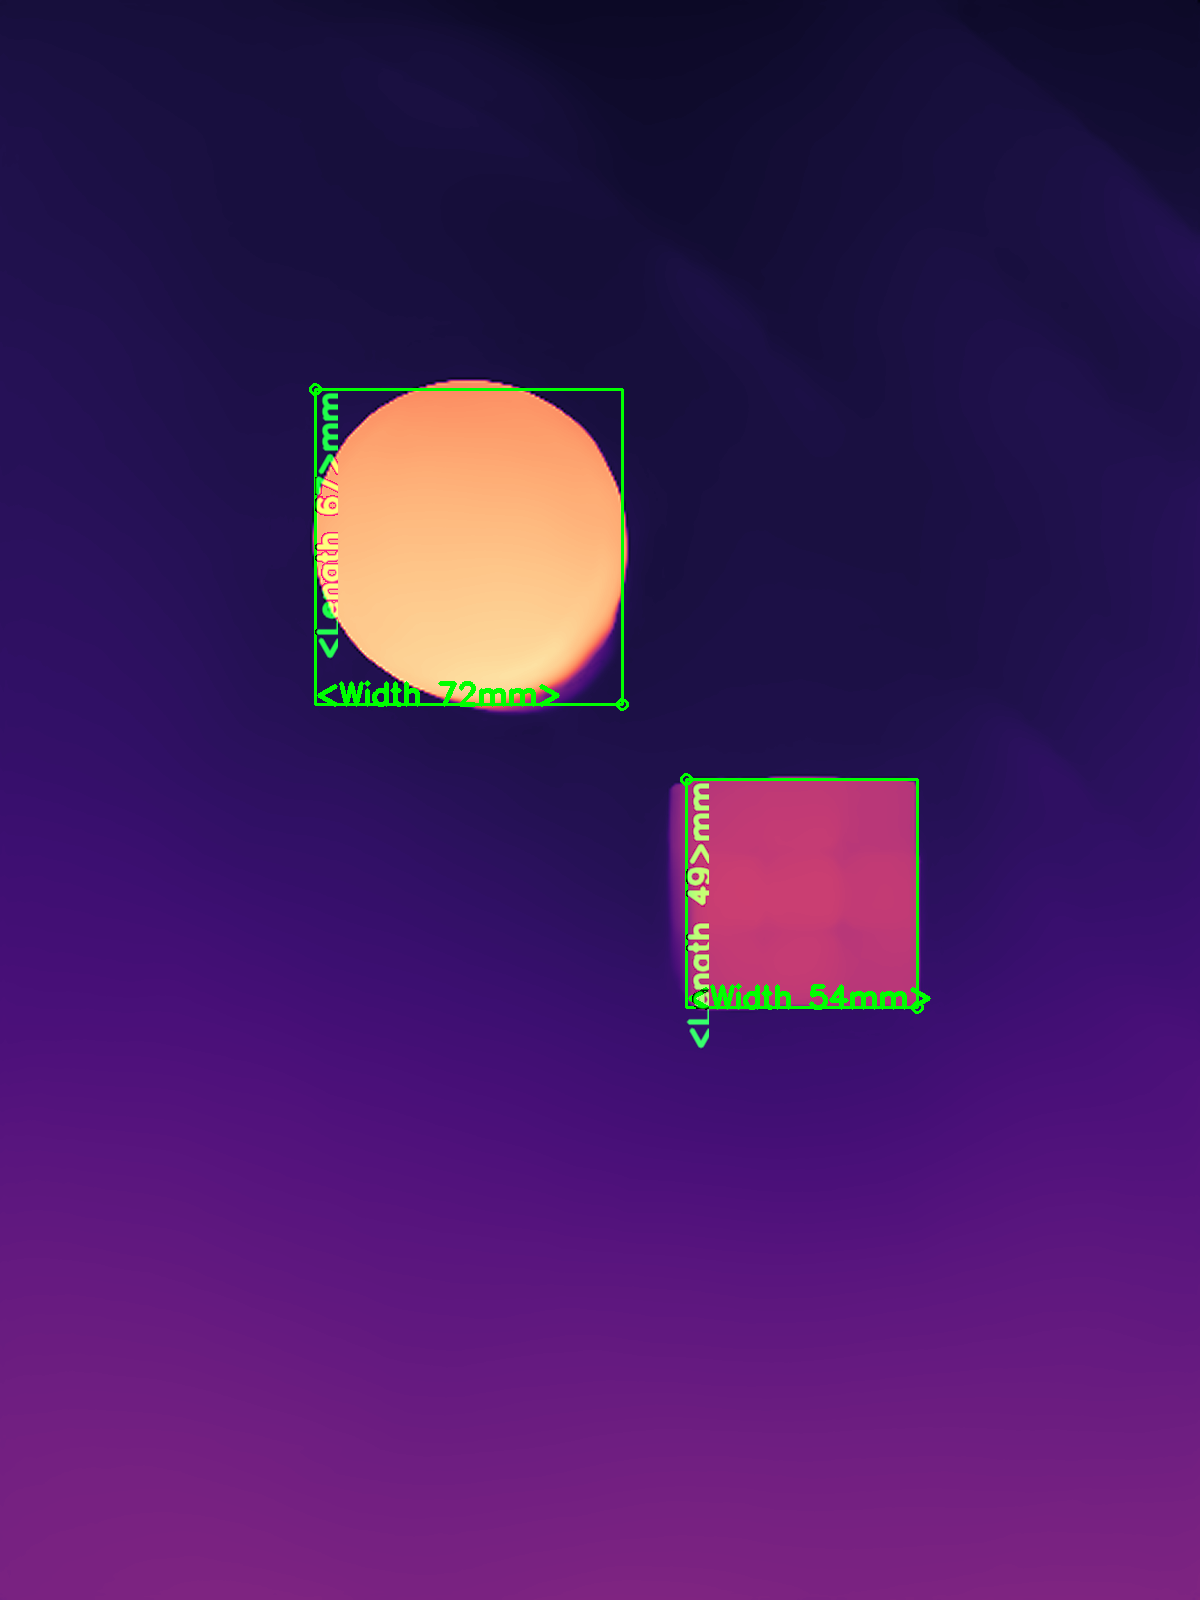

In [361]:
bounding_boxes = []
temp = depth_color.copy()
camh = int(input("Enter Cam Height:"))  #289 for the below image
ref_h = float(input("Enter Reference Obj Height"))
for i in range(nom_of_abjects):
  dx,dy,tl_p,br_p = sad(camheight=300,depthmap = temp, mask=masks[i])
  x,y = view(dx,dy,px=initial_image.shape[0],py=initial_image.shape[1],f=5.42,viewport=[6.144,8.6],camh=289)
  cv2.circle(temp,tl_p , 5, (0, 255, 0), 2)
  cv2.circle(temp,br_p , 5, (0, 255, 0), 2)
  cv2.rectangle(temp,tl_p , br_p, (0, 255, 0), 2)
  bounding_boxes.append([tl_p,br_p])
  cv2.putText(temp,f"<Width {int(x)}mm>",(tl_p[0],br_p[1]),cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,thickness=3,color = (0, 255, 0))
  temp = vertical_text(temp,f"<Length {int(y)}>mm",tl_p)
cv2_imshow(temp)

In [362]:
ref = mean_depth(depth_color, (0,0),bounding_boxes[0][0])    # Reference Value for camH

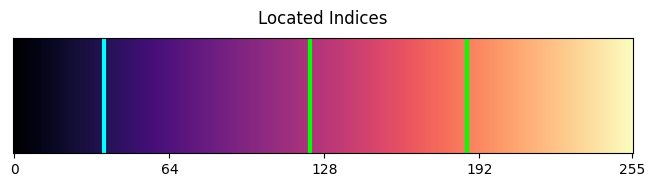

[np.float64(187.00710401395298), np.float64(122.03334929298732)]


In [363]:
values = np.linspace(0, 255, 256).reshape(1, -1)
plt.figure(figsize=(8, 1.5))
plt.imshow(values, cmap='magma', aspect='auto')
mean_val = []
min1=255
for i in range(nom_of_abjects):
  depth_copy = depth_color.copy()
  _01img = masks[i]//255
  meanint = depth_copy[_01img==1].mean()
  if(ref < meanint < min1):
    min1 = meanint
  mean_val.append(meanint)
  plt.axvline(x=meanint, color='lime', linewidth=3)
plt.axvline(x=ref, color='cyan', linewidth=3)
plt.yticks([])
plt.xticks([0, 64, 128, 192, 255], ['0', '64', '128', '192', '255'])
plt.title("Located Indices", pad=10)
plt.show()
print(mean_val)

[np.float64(187.00710401395298), np.float64(122.03334929298732)] 84.98262364997376
thats it


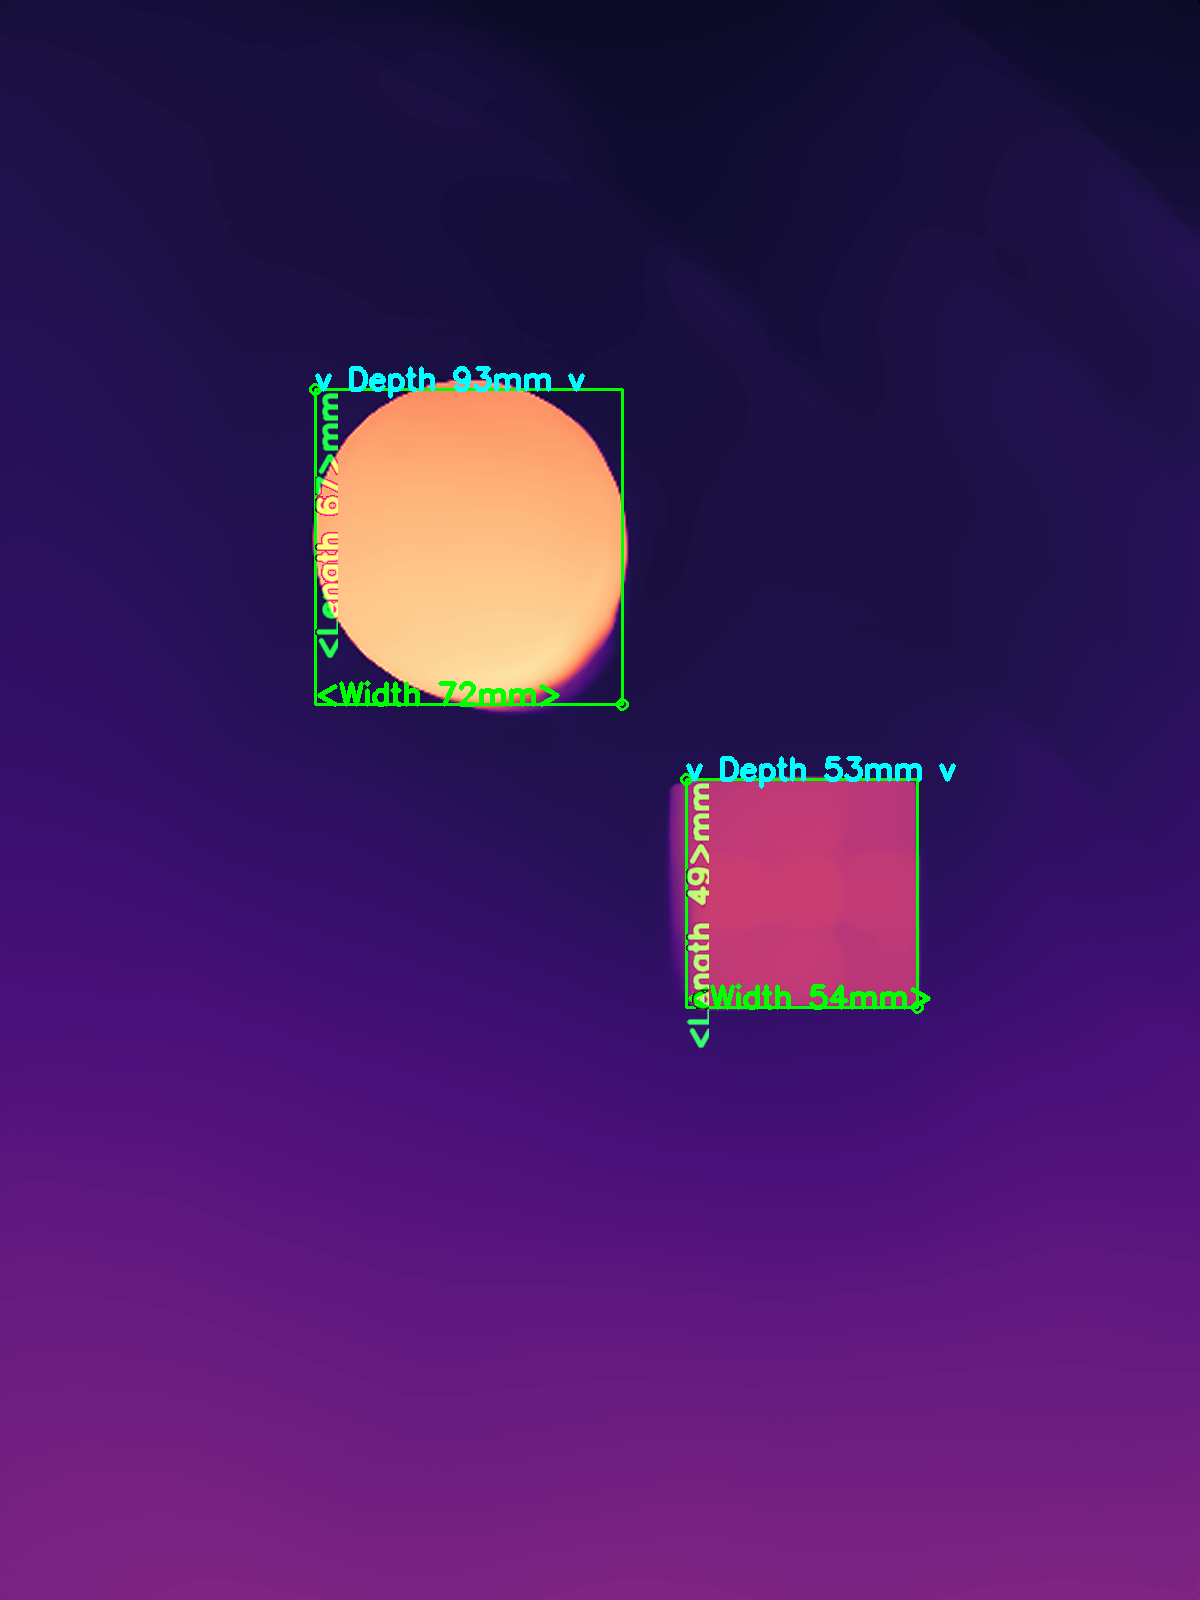

In [364]:
scaler = float(min1-ref)
print(mean_val,scaler)
print("thats it")

for i in range(0,nom_of_abjects):
    temph = (float(mean_val[i]-ref)/scaler)*ref_h
    mid_X = int((bounding_boxes[i][0][0]+bounding_boxes[i][1][0])/2.)
    mid_Y = int((bounding_boxes[i][0][1]+bounding_boxes[i][1][1])/2.)
    if(temph==ref_h):cv2.putText(temp,f"v Depth {int(temph)}mm v", org = bounding_boxes[i][0], fontFace=cv2.FONT_HERSHEY_SIMPLEX , fontScale=1 , thickness=3 , color = (255, 255, 0))
    else: cv2.putText(temp,f"v Depth {int(temph)}mm v", org = bounding_boxes[i][0], fontFace=cv2.FONT_HERSHEY_SIMPLEX , fontScale=1 , thickness=3 , color = (255, 255, 0))
cv2_imshow(temp)

#Since By design the cmap is perceived as linear and the depth(in grayscale) increases linearly
